# plant pathology 2021图片分类

plant pathology 2021为叶片图片数据集

## 引入数据集

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import random
import PIL
import seaborn as sns
import matplotlib.pyplot as plt
import skimage.io as io
import zipfile

print(torch.__version__)

path = './plant_dataset'

os.listdir(path)

1.8.0


['train', '.ipynb_checkpoints', 'val', 'test']

In [2]:
class Config: 
    """
    """
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    INPUT_PATH = './plant_dataset'
    OUTPUT_PATH = './'
    N_EPOCH = 30
    BATCH_SIZE = 6
    RANDOM_STATE = 42
    SAMPLE_FRAC = 1.0
    IMG_SIZE = 224
    LEARNING_RATE = 0.0001
    TRAIN_DATA_FILE = './plant_dataset/train/train_label.csv'
    MODEL_ONNX_FILE = './plant2021_cuda.onnx'
    INPUT_MODEL_FILE = './input/plant2021_cuda.pth' 
    OUTPUT_MODEL_FILE = './plant2021_cuda.pth'
    CLASSES = [
        'powdery_mildew',
        'rust', 
        'complex', 
        'healthy', 
        'frog_eye_leaf_spot',
        'scab', 
    ]
    N_CLASSES = len(CLASSES)
    
    folders = dict({
        'data': INPUT_PATH,
        'train': './plant_dataset/train',
        'val': './plant_dataset/val',
        'test':  './plant_dataset/test'
    })
    
    @staticmethod
    def set_seed():
        torch.manual_seed(Config.RANDOM_STATE)
        random.seed(Config.RANDOM_STATE)
        np.random.seed(Config.RANDOM_STATE)
        
Config.set_seed()   

## 修改标签
### 将图片标签从12类修改为6类
![resnet-1](./6labels.png)

## 分析图片类别

In [3]:
def change_to_6(data):
    data.replace('scab frog_eye_leaf_spot', 'scab', inplace=True)
    data.replace('scab frog_eye_leaf_spot complex', 'scab', inplace=True)
    data.replace('frog_eye_leaf_spot complex', 'frog_eye_leaf_spot', inplace=True)
    data.replace('rust frog_eye_leaf_spot', 'rust', inplace=True)
    data.replace('rust complex', 'rust', inplace=True)
    data.replace('powdery_mildew complex', 'powdery_mildew', inplace=True)
    return data

def get_image_infos(img_labels):
    """
    """
    df = img_labels.reset_index().groupby(by='labels').count().reset_index()
    df.columns = ['disease', 'count']
    
    df['%'] = np.round((df['count'] / img_labels.shape[0]), 2) * 100
    df = df.set_index('disease').sort_values(by='count', ascending=False)

    return df

train=pd.read_csv(path + "/train/train_label.csv").set_index('images')
test=pd.read_csv(path + "/test/test_label.csv").set_index('images')
val=pd.read_csv(path + "/val/val_label.csv").set_index('images')

train = change_to_6(train)
test = change_to_6(test)
val = change_to_6(val)

get_image_infos(train.labels)

,count,%
disease,,
scab,897,30.0
healthy,753,25.0
frog_eye_leaf_spot,550,18.0
rust,347,12.0
complex,256,9.0
powdery_mildew,197,7.0


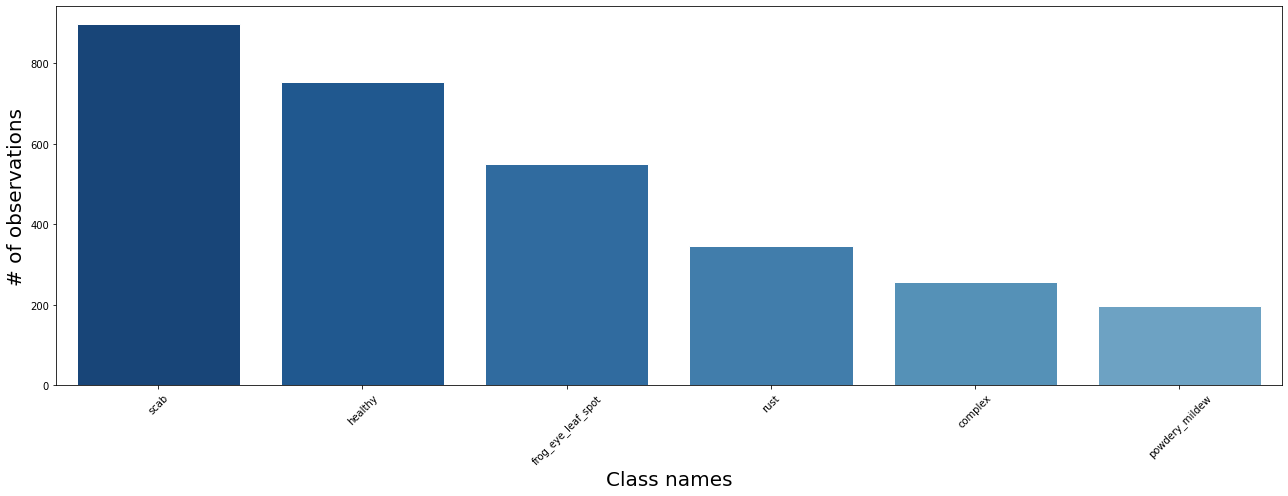

In [4]:
def plot_image_counts(img_labels):
    fig, ax = plt.subplots(figsize=(18, 7))
    sns.set_style("whitegrid")
    palette = sns.color_palette("Blues_r", 12)

    sns.countplot(
        x='labels', 
        palette=palette,
        data=img_labels,
        order=img_labels['labels'].value_counts().index,
    );

    plt.ylabel("# of observations", size=20);
    plt.xlabel("Class names", size=20)

    plt.xticks(rotation=45)
    
    fig.tight_layout()
    plt.show()
    
    
plot_image_counts(train)  

## One hot 编码

In [5]:
def get_single_labels(unique_labels):
    """Splitting multi-labels and returning a list of classes"""
    single_labels = []
    
    for label in unique_labels:
        single_labels += label.split()
        
    single_labels = set(single_labels)
    return list(single_labels)


def get_one_hot_encoded_labels(dataset_df):
    """
    """
    df = dataset_df.copy()
    
    unique_labels = df.labels.unique()
    column_names = get_single_labels(unique_labels)
    
    df[column_names] = 0
    
    # one-hot-encoding
    for label in unique_labels:                
        label_indices = df[df['labels'] == label].index
        splited_labels = label.split()
        df.loc[label_indices, splited_labels] = 1
    
    return df

one_hot_test = get_one_hot_encoded_labels(test)
one_hot_train = get_one_hot_encoded_labels(train)
one_hot_val = get_one_hot_encoded_labels(val)
one_hot_train.head(10)

,labels,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew,healthy
images,,,,,,,
a8ab965f868fc44c.jpg,healthy,0,0,0,0,0,1
a5d8924f7fad18a0.jpg,healthy,0,0,0,0,0,1
fab3f2b1c0d2a982.jpg,scab,1,0,0,0,0,0
d9b283cd98b19d13.jpg,scab,1,0,0,0,0,0
852979c129dde25d.jpg,frog_eye_leaf_spot,0,1,0,0,0,0
b76b84406eb75545.jpg,healthy,0,0,0,0,0,1
c1a972977e88b49c.jpg,complex,0,0,1,0,0,0
ba3457285a4655e7.jpg,scab,1,0,0,0,0,0
f2d5d2adc18c6986.jpg,scab,1,0,0,0,0,0


## 图片可视化

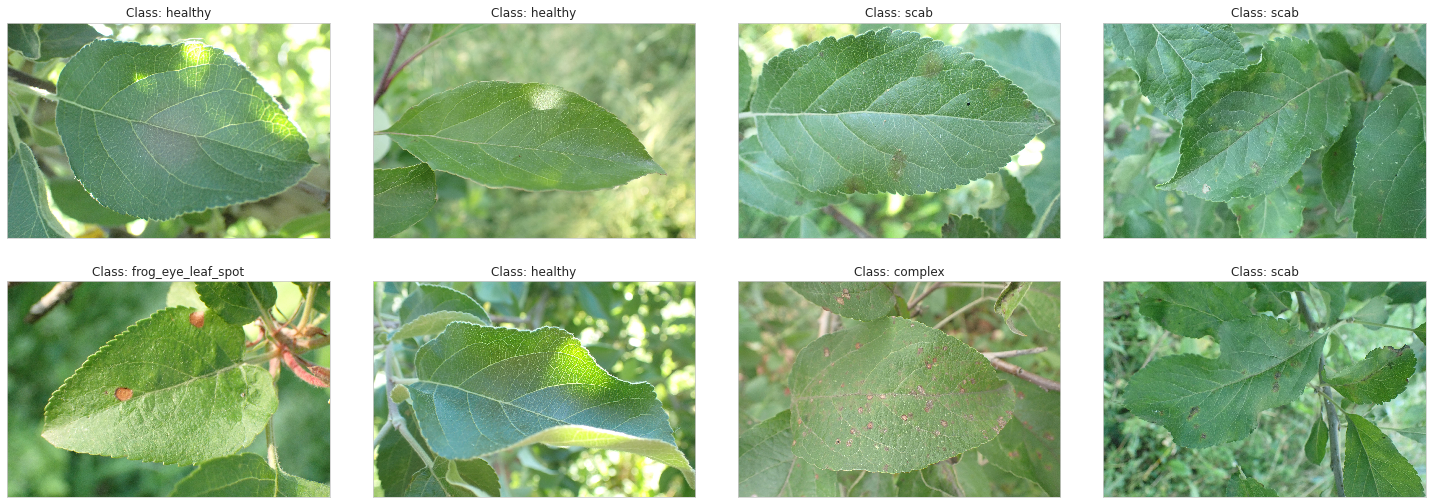

In [6]:
def get_image(image_id, kind='train'):
    """Loads an image from file
    """
    fname = Config.folders[kind] + '/images/' + image_id
    return PIL.Image.open(fname)

def visualize_images(image_ids, labels, nrows=1, ncols=4, kind='train', image_transform=None):
    """
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    for image_id, label, ax in zip(image_ids, labels, axes.flatten()):
        
        fname = Config.folders[kind] + '/images/' + image_id
        image = np.array(PIL.Image.open(fname))
        
        if image_transform:
            image = transform = A.Compose(
                [t for t in image_transform.transforms if not isinstance(t, (
                    A.Normalize, 
                    ToTensorV2
                ))])(image=image)['image']
        
        io.imshow(image, ax=ax)
        
        ax.set_title(f"Class: {label}", fontsize=12)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        del image
        
    plt.show()    
    
# 可视化训练图片
visualize_images(train.index, train.labels, nrows=2, ncols=4)

## 增强数据集

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
#     A.Rotate(
#         always_apply=False, 
#         p=0.1, 
#         limit=(-68, 178), 
#         interpolation=1, 
#         border_mode=0, 
#         value=(0, 0, 0), 
#         mask_value=None
#     ),
#     A.RandomShadow(
#         num_shadows_lower=1, 
#         num_shadows_upper=1, 
#         shadow_dimension=3, 
#         shadow_roi=(0, 0.6, 1, 1), 
#         p=0.4
#     ),
    A.ShiftScaleRotate(
        shift_limit=0.05, 
        scale_limit=0.05, 
        rotate_limit=15, 
        p=0.6
    ),
#     A.RandomFog(
#         fog_coef_lower=0.2, 
#         fog_coef_upper=0.2, 
#         alpha_coef=0.2, 
#         p=0.3
#     ),
    # A.RGBShift(
    #     r_shift_limit=15, 
    #     g_shift_limit=15, 
    #     b_shift_limit=15, 
    #     p=0.3
    # ),
    A.RandomBrightnessContrast(
        p=0.3
    ),
#     A.GaussNoise(
#         var_limit=(50, 70),  
#         always_apply=False, 
#         p=0.3
#     ),
    A.Resize(
        height=Config.IMG_SIZE,
        width=Config.IMG_SIZE,
    ),
    # A.CoarseDropout(
    #     max_holes=5, 
    #     max_height=5, 
    #     max_width=5, 
    #     min_holes=3, 
    #     min_height=5, 
    #     min_width=5,
    #     always_apply=False, 
    #     p=0.2
    # ),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(
        height=Config.IMG_SIZE,
        width=Config.IMG_SIZE,
    ),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

## 可视化增强后的图片

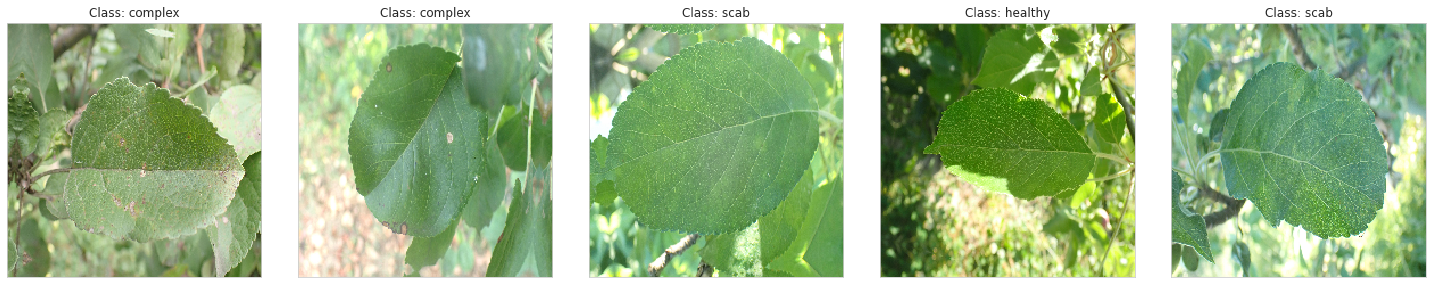

In [8]:
train_images = train.sample(n=5)

visualize_images(
    train_images.index, 
    train_images.labels, 
    nrows=1,
    ncols=5,
    image_transform=train_transform,
    kind='train'
)

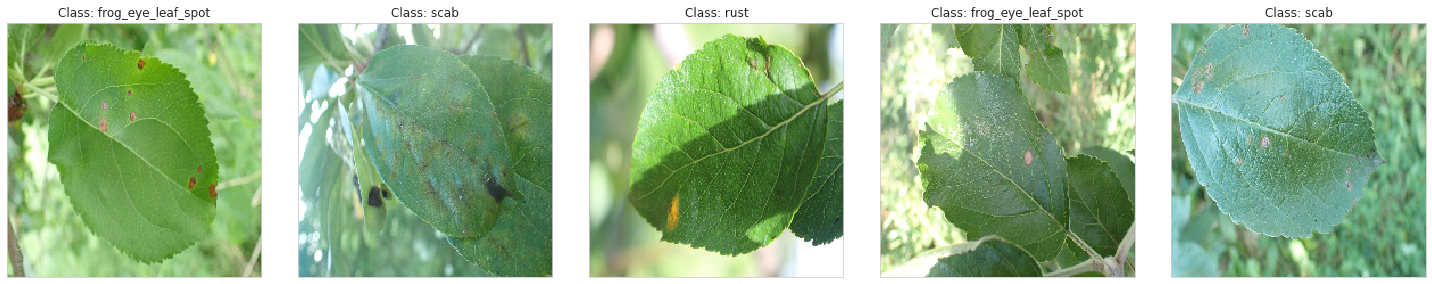

In [9]:
test_images = test.sample(n=5)

visualize_images(
    test_images.index, 
    test_images.labels, 
    nrows=1,
    ncols=5,
    image_transform=val_transform,
    kind='test'
)

## 设置数据集

In [10]:
from scipy.stats import bernoulli
from torch.utils.data import Dataset

class PlantDataset(Dataset):
    """
    """
    def __init__(self, 
                 image_ids, 
                 targets,
                 transform=None, 
                 target_transform=None, 
                 kind='train'):
        self.image_ids = image_ids
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        self.kind = kind
         
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # load and transform image
        img = np.array(get_image(self.image_ids.iloc[idx], kind=self.kind))
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        # get image target 
        target = self.targets[idx]
        if self.target_transform:
            target = self.target_transform(target)
        
        return img, target

x_train = pd.Series(train.index) 
x_val = pd.Series(val.index) 
y_train = np.array(one_hot_train[Config.CLASSES])
y_val = np.array(one_hot_val[Config.CLASSES])
x_test = pd.Series(test.index) 
y_test = np.array(one_hot_test[Config.CLASSES])

In [24]:
train_set = PlantDataset(x_train, y_train, transform=train_transform, kind='train')
val_set = PlantDataset(x_val, y_val, transform=val_transform, kind='val')
test_set = PlantDataset(x_test, y_test, transform=val_transform, kind='test')

print(f'Train size: {len(train_set)}')
print(f'Validation size: {len(val_set)}')
print(f'test size: {len(test_set)}')

Train size: 3000
Validation size: 600
test size: 600


In [25]:
from torch.utils.data import DataLoader
from torch.nn import BatchNorm2d

train_loader = DataLoader(train_set, batch_size=Config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=Config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=Config.BATCH_SIZE, shuffle=True)

## ResNet 模型

In [13]:
from torch import nn
class Bottleneck(nn.Module):
    #每个stage维度中扩展的倍数
    extention=4
    def __init__(self,inplanes,planes,stride,downsample=None):
        '''

        :param inplanes: 输入block的之前的通道数
        :param planes: 在block中间处理的时候的通道数
                planes*self.extention:输出的维度
        :param stride:
        :param downsample:
        '''
        super(Bottleneck, self).__init__()

        self.conv1=nn.Conv2d(inplanes,planes,kernel_size=1,stride=stride,bias=False)
        self.bn1=nn.BatchNorm2d(planes)

        self.conv2=nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(planes)

        self.conv3=nn.Conv2d(planes,planes*self.extention,kernel_size=1,stride=1,bias=False)
        self.bn3=nn.BatchNorm2d(planes*self.extention)

        self.relu=nn.ReLU(inplace=True)

        #判断残差有没有卷积
        self.downsample=downsample
        self.stride=stride

    def forward(self,x):
        #参差数据
        residual=x

        #卷积操作
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)

        out=self.conv2(out)
        out=self.bn2(out)
        out=self.relu(out)

        out=self.conv3(out)
        out=self.bn3(out)
        out=self.relu(out)

        #是否直连（如果Indentity blobk就是直连；如果Conv2 Block就需要对残差边就行卷积，改变通道数和size
        if self.downsample is not None:
            residual=self.downsample(x)

        #将残差部分和卷积部分相加
        out+=residual
        out=self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self,block,layers,num_class):
        #inplane=当前的fm的通道数
        self.inplane=64
        super(ResNet, self).__init__()

        #参数
        self.block=block
        self.layers=layers

        #stem的网络层
        self.conv1=nn.Conv2d(3,self.inplane,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(self.inplane)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        #64,128,256,512指的是扩大4倍之前的维度，即Identity Block中间的维度
        self.stage1=self.make_layer(self.block,64,layers[0],stride=1)
        self.stage2=self.make_layer(self.block,128,layers[1],stride=2)
        self.stage3=self.make_layer(self.block,256,layers[2],stride=2)
        self.stage4=self.make_layer(self.block,512,layers[3],stride=2)

        #后续的网络
        self.avgpool=nn.AvgPool2d(7)
        self.fc=nn.Linear(512*block.extention,num_class)

    def forward(self,x):
        #stem部分：conv+bn+maxpool
        out=self.cuda().conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.maxpool(out)

        #block部分
        out=self.stage1(out)
        out=self.stage2(out)
        out=self.stage3(out)
        out=self.stage4(out)

        #分类
        out=self.avgpool(out)
        out=torch.flatten(out,1)
        out=self.fc(out)

        return out

    def make_layer(self,block,plane,block_num,stride=1):
        '''
        :param block: block模板
        :param plane: 每个模块中间运算的维度，一般等于输出维度/4
        :param block_num: 重复次数
        :param stride: 步长
        :return:
        '''
        block_list=[]
        #先计算要不要加downsample
        downsample=None
        if(stride!=1 or self.inplane!=plane*block.extention):
            downsample=nn.Sequential(
                nn.Conv2d(self.inplane,plane*block.extention,stride=stride,kernel_size=1,bias=False),
                nn.BatchNorm2d(plane*block.extention)
            )

        # Conv Block输入和输出的维度（通道数和size）是不一样的，所以不能连续串联，他的作用是改变网络的维度
        # Identity Block 输入维度和输出（通道数和size）相同，可以直接串联，用于加深网络
        #Conv_block
        conv_block=block(self.inplane,plane,stride=stride,downsample=downsample)
        block_list.append(conv_block)
        self.inplane=plane*block.extention

        #Identity Block
        for i in range(1,block_num):
            block_list.append(block(self.inplane,plane,stride=1))

        return nn.Sequential(*block_list)

In [14]:
import torchvision
def create_model(pretrained=True):
    model = torchvision.models.resnet50(pretrained=pretrained).to(Config.DEVICE)
    
    for param in model.layer1.parameters():
        param.requires_grad = False
        
    for param in model.layer2.parameters():
        param.requires_grad = False  
        
    for param in model.layer3.parameters():
        param.requires_grad = False 
    
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=model.fc.in_features,
            out_features=Config.N_CLASSES
        ),
        torch.nn.Sigmoid()
    ).to(Config.DEVICE)
    
    return model

model = create_model(pretrained=True).cuda()

## 训练模型

In [15]:
class MetricMonitor:
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.accuracies = []
        self.scores = []
        self.metrics = dict({
            'loss': self.losses,
            'acc': self.accuracies,
            'f1': self.scores
        })

    def update(self, metric_name, value):
        self.metrics[metric_name] += [value]

train_monitor = MetricMonitor()
test_monitor = MetricMonitor()

In [16]:
from sklearn.metrics import f1_score, accuracy_score

def get_metrics(
    y_pred_proba, 
    y_test, 
    labels=Config.CLASSES) -> None:
    """
    """
    threshold = 0.6
    y_pred = np.where(y_pred_proba > threshold, 1, 0)

    y1 = y_pred.round().astype(float)
    y2 = y_test.round().astype(float)
    
    f1 = f1_score(y1, y2, average='micro')
    acc = accuracy_score(y1, y2, normalize=True)

    return acc,f1

def to_numpy(tensor):
    """Auxiliary function to convert tensors into numpy arrays
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [17]:
def training_loop(
    dataloader, 
    model, 
    loss_fn, 
    optimizer, 
    epoch, 
    monitor = MetricMonitor(), 
    is_train=True
) -> None:
    """
    """
    size = len(dataloader.dataset)
    
    loss_val = 0
    accuracy = 0
    f1score = 0
        
    if is_train:
        model.train()
    else:
        model.eval()
    
    stream = tqdm(dataloader)
    for batch, (X, y) in enumerate(stream, start=1):
        X = X.cuda()
        y = y.cuda()
        
        # compute prediction and loss
        pred_prob = model(X)
        loss = loss_fn(pred_prob, y)

        if is_train:
            # backpropagation
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
        loss_val += loss.item()
        acc, f1 = get_metrics(to_numpy(pred_prob), to_numpy(y))
        
        accuracy += acc 
        f1score += f1

        phase = 'Train' if is_train else 'Val'
        stream.set_description(
            f'Epoch {epoch:3d}/{Config.N_EPOCH} - {phase} - Loss: {loss_val/batch:.4f}, ' + 
            f'Acc: {accuracy/batch:.4f}, F1: {f1score/batch:.4f}'
        )

    monitor.update('loss', loss_val/batch)
    monitor.update('acc', accuracy/batch)
    monitor.update('f1', f1score/batch) 

In [18]:
import torch.nn as nn

# initialize the loss function
loss_fn = nn.MultiLabelSoftMarginLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=Config.LEARNING_RATE
)

In [19]:
from tqdm import *
# %%time
for epoch in range(1, Config.N_EPOCH + 1):
    # training loop
    training_loop(
        train_loader, 
        model, 
        loss_fn, 
        optimizer, 
        epoch, 
        train_monitor,
        is_train=True
    )
    
    # validation loop
    training_loop(
        valid_loader, 
        model, 
        loss_fn, 
        optimizer, 
        epoch, 
        test_monitor,
        is_train=False
    )

Epoch   1/30 - Train - Loss: 0.6881, Acc: 0.2927, F1: 0.3987: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]
Epoch   1/30 - Val - Loss: 0.6625, Acc: 0.6350, F1: 0.7294: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]
Epoch   2/30 - Train - Loss: 0.6693, Acc: 0.5163, F1: 0.6346: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]
Epoch   2/30 - Val - Loss: 0.6554, Acc: 0.6817, F1: 0.7817: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]
Epoch   3/30 - Train - Loss: 0.6633, Acc: 0.5803, F1: 0.6951: 100%|██████████| 500/500 [06:41<00:00,  1.25it/s]
Epoch   3/30 - Val - Loss: 0.6562, Acc: 0.7367, F1: 0.7992: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]
Epoch   4/30 - Train - Loss: 0.6604, Acc: 0.6283, F1: 0.7356: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]
Epoch   4/30 - Val - Loss: 0.6542, Acc: 0.7383, F1: 0.8094: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]
Epoch   5/30 - Train - Loss: 0.6584, Acc: 0.6503, F1: 0.7535: 100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


## 可视化训练

In [20]:
from matplotlib.ticker import MaxNLocator 

def plot_result(
    train_losses, 
    test_losses, 
    train_accuracies, 
    test_accuracies, 
    train_scores,
    test_scores
) -> None:
    
    epochs = range(1, len(train_losses) + 1)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
    
    # plot loss values
    ax[0].plot(epochs, train_losses, label='Training loss', marker ='o')
    ax[0].plot(epochs, test_losses, label='Validation loss', marker ='o')
    ax[0].legend(frameon=False, fontsize=14)
    
    ax[0].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[0].set_title('Loss', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14) 
    ax[0].set_ylabel('Loss', fontsize=14)  
    
    # plot accuracies 
    ax[1].plot(epochs, train_accuracies, label='Training Accuracy', marker ='o')
    ax[1].plot(epochs, test_accuracies, label='Validation accuracy', marker ='o')
    ax[1].legend(frameon=False, fontsize=14)
    
    ax[1].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[1].set_title('Accuracy', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14) 
    ax[1].set_ylabel('Accuracy', fontsize=14)
    
    ax[2].plot(epochs, train_scores, label='Training F1-Score', marker ='o')
    ax[2].plot(epochs, test_scores, label='Validation F1-Score', marker ='o')
    ax[2].legend(frameon=False, fontsize=14)
    
    ax[2].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[2].set_title('F1-Score', fontsize=18)
    ax[2].set_xlabel('Epoch', fontsize=14) 
    ax[2].set_ylabel('F1-Score', fontsize=14) 
        
    plt.show()

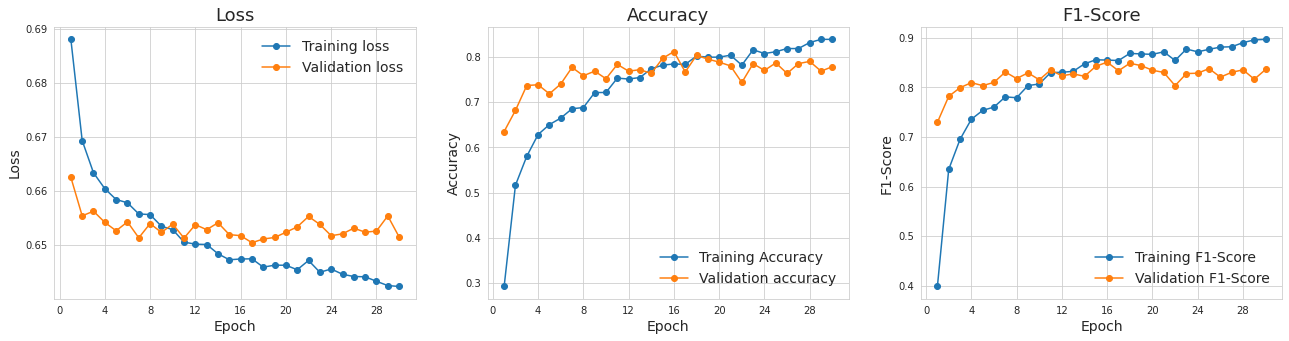

In [21]:
plot_result(
    train_monitor.losses, 
    test_monitor.losses,
    train_monitor.accuracies, 
    test_monitor.accuracies, 
    train_monitor.scores,
    test_monitor.scores
)    

## 导出模型

In [22]:
def export_model(model):
    dummy_input = torch.randn([
        Config.BATCH_SIZE, 
        3, 
        Config.IMG_SIZE, 
        Config.IMG_SIZE
    ]).to(Config.DEVICE)
    dummy_output = model(dummy_input)

    # Export the model
    torch.onnx.export(
        model,               
        dummy_input,                        
        Config.MODEL_ONNX_FILE,   
        export_params=True,        
        opset_version=10,          # the ONNX version to export the model to
        do_constant_folding=True,   
        input_names = ['input'],   # the model's input names
        output_names = ['output'], # the model's output names
        dynamic_axes=
        {
            'input': { 0: 'batch_size'},    # variable lenght axes
            'output': { 0: 'batch_size'}
        }
    )

    
def load_model(model, load_path=Config.INPUT_MODEL_FILE):
    model.load_state_dict(torch.load(load_path))
    model.eval()
    
def save_weights(model, save_path=Config.OUTPUT_MODEL_FILE):
    torch.save(model.state_dict(), save_path)

    
export_model(model) # export model as ONNX
save_weights(model)

## 混淆矩阵

In [26]:
batch = Config.BATCH_SIZE

y_true = np.empty(shape=(0, 6), dtype=np.int)
y_pred_proba = np.empty(shape=(0, 6), dtype=np.int)

stream = tqdm(test_loader)
for batch, (X, y) in enumerate(stream, start=1):
    X = X.cuda()
    y = to_numpy(y.cuda())
    pred = to_numpy(model(X))
    
    y_true = np.vstack((y_true, y))
    y_pred_proba = np.vstack((y_pred_proba, pred))

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


In [32]:
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(
    y_test, 
    y_pred_proba, 
    label_names=Config.CLASSES
)-> None:
    """
    """
    y_pred = np.where(y_pred_proba > 0.6, 1, 0)
    
    c_matrices = multilabel_confusion_matrix(y_test, y_pred)
    
    cmap = plt.get_cmap('Blues')
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

    for cm, label, ax in zip(c_matrices, label_names, axes.flatten()):
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=cmap);

        ax.set_xlabel('Predicted labels');
        ax.set_ylabel('True labels'); 
        ax.set_title(f'{label}');

    plt.tight_layout()    
    plt.show()

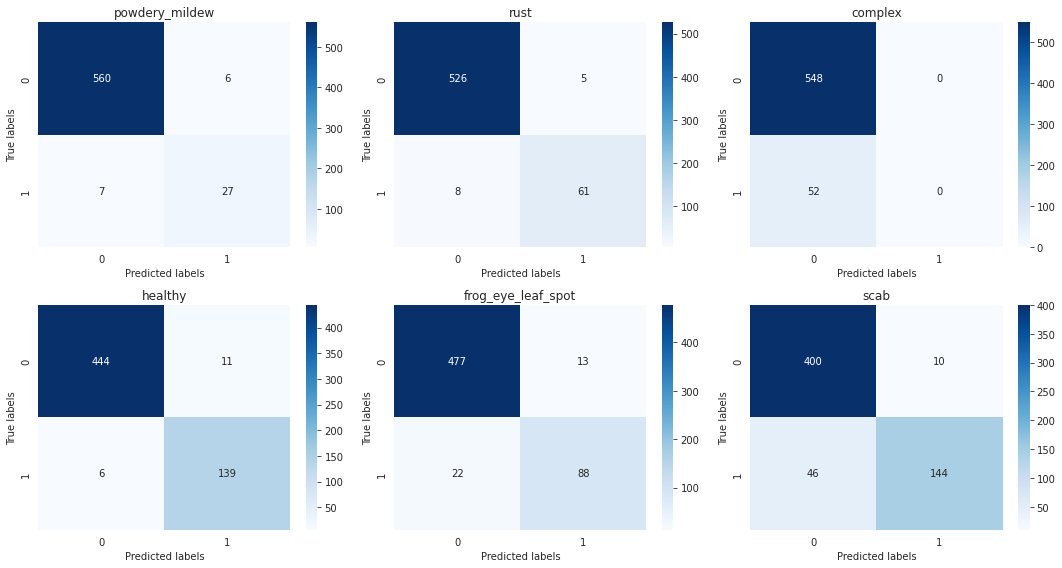

In [33]:
plot_confusion_matrix(y_true, y_pred_proba) 

## 测试分数

In [39]:
y_pred = np.where(y_pred_proba > 0.3, 1, 0)
        
accuracy, f1 = get_metrics(y_pred, y_true)

pd.DataFrame({
    'name': ['F1', 'Accuracy'],
    'sorce': [f1, accuracy]
}).set_index('name')

,sorce
name,
F1,0.840889
Accuracy,0.781667
